#**Visualizing Intermediary Layer Activation Output**

First, we load our trained CNN...

In [5]:
from tensorflow import keras 
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

conv_net = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras")

Mounted at /content/drive


Next, we load an impage to feed through the model...

204800/195096 [===============================] - 0s 0us/step


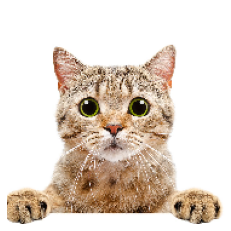

In [180]:
img_path = keras.utils.get_file(
    fname="cat10.jpg",
    origin="https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=49ed3252c0b2ffb49cf8b508892e452d")
 
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
  
img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [181]:
from tensorflow.keras import layers
  
layer_outputs = []
layer_names = [] 

# We are making a 'new' Keras model based on the trained one.

# For each layer in the trained model.
for layer in conv_net.layers:
    # If that layer is a 2D Convolution or a Max Pool layer.
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        
        # Take that layer's outputs and name and append them to a list
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Finally, define the new model as the trained model's inputs, mapped to the set of outputs we just defined above.
# So, the new model takes the same set of inputs as the trained model, but it spits out intermediate activation outputs from each Conv2D and MaxPool2D layer. 
activation_model = keras.Model(inputs=conv_net.input, outputs=layer_outputs)

(1, 178, 178, 32)


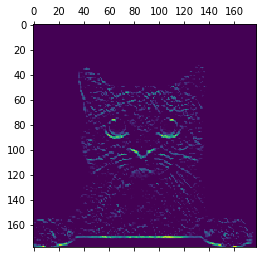

In [182]:
import matplotlib.pyplot as plt

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# Let's plot the 1st feature map from the first Convolution layer.
# It seems to be detecting some edges.
plt.matshow(first_layer_activation[0, :, :, 0], cmap="viridis")
plt.show()

#**Class Activation Heatmaps**

Let's get the prediction for our cat image... note that our model actually doesn't do well here; it predicts incorrectly.

In [196]:
preds = conv_net.predict(img_tensor)
print(f'Probability that this is a dog = {preds[0]}')

if np.round(preds[0]) == 0:
  print(f'Predicted class is cat.')
else:
  print(f'Predicted class is dog.')

Probability that this is a dog = [0.80773926]
Predicted class is dog.


Let's get the names of the layers from our model...

In [197]:
for layer in conv_net.layers:
    print(layer.name)

input_1
rescaling
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
flatten
dense


Now, we make two more Keras models. The first one just takes a picture as input and feeds it through the CNN layers of the trained model. The second takes the output from the CNN layers, and feeds it through the dense layer to a prediction output. 

In [202]:
# The CNN base layers of our model.
last_conv_layer_name = "conv2d_4" 
classifier_layer_names = [
    "flatten",
    "dense",
]
last_conv_layer = conv_net.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(conv_net.inputs, last_conv_layer.output)

# The final dense layers of our model. 
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input 
for layer_name in classifier_layer_names:
    x = conv_net.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Now, we use GradientTape() to look at gradient of the class prediction w.r.t. activations that are coming out of the convolutional base-layers. 

In [215]:
import tensorflow as tf
  
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    print(f'CNN base output shape is: {last_conv_layer_output.shape}')
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    print(f'Prediction output is {preds}.')
    pr_dog = preds[0]
    
grads = tape.gradient(pr_dog, last_conv_layer_output)

CNN base output shape is: (1, 7, 7, 256)
Prediction output is [[0.8077383]].


Now, we construct our heatmap. We take the product of the CNN base output (feature maps) and the gradients, to see what's most influencing 

(1, 7, 7, 256)
(256,)
(1, 7, 7, 256)
(7, 7, 256)


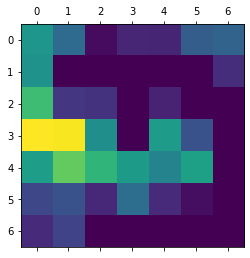

In [216]:
print(grads.shape)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
print(pooled_grads.shape)

print(last_conv_layer_output.shape)
last_conv_layer_output = last_conv_layer_output.numpy()[0]
print(last_conv_layer_output.shape)

# Here we are multiplying the CNN base output feature maps by the average gradient associated with each one... positive gradients are driving toward 1, negative toward 0.
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# We then make our heatmap as the average value in each element position across the 256 gradient-weighted feature maps.
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

It appears to be something about the 'snout' that's driving the prediction. But, unfortunately, also the background!

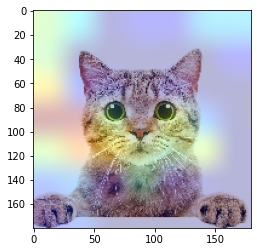

In [217]:
import matplotlib.cm as cm
  
img = img_tensor[0,:,:,:]

heatmap = np.uint8(255 * heatmap)
 
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
 
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
 
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)
plt.show()